# Tutorial introduction to variational state-space models


In [1]:
%load_ext autoreload 
%matplotlib inline   

import theano
import theano.tensor as T
import theano.tensor.nlinalg as Tla
import lasagne       
from lasagne.nonlinearities import leaky_rectify, softmax, linear, tanh, rectify, sigmoid
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
from numpy.random import *
from matplotlib import pyplot as plt
import scipy.io
import cPickle
import sys
import funs
# I always initialize random variables here. 
msrng = RandomStreams(seed=20150503)
mnrng = np.random.RandomState(20150503)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\kdais\Anaconda3\envs\py27\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
theano.config.optimizer = 'fast_compile'

# Add all the paths that should matter right now
sys.path.append('lib')  # support files (mathematical tools, mostly)

from GenerativeModel import *       # Class file for generative models. 
from RecognitionModel_simdir import *      # Class file for recognition models
from SGVB_simdir import *                  # The meat of the algorithm - define the ELBO and initialize Gen/Rec model

# Generative models and sampling

The GenerativeModel.py file contains an abstract Generative model class, and implementations of a few example generative models: LDS (Kalman filter model), PLDS (LDS with Poisson count observations). The abstract GenerativeModel class describes all the functions you must implement to define a new GenerativeModel: methods for sampling from the model and and evaluating its log likelihood.


When initializing a new GenerativeModel instance, you define all its parameters in a dictionary. For the LDS and PLDS classes, most parameters have random initializations that will be used if they are not specified in the dictionary. 


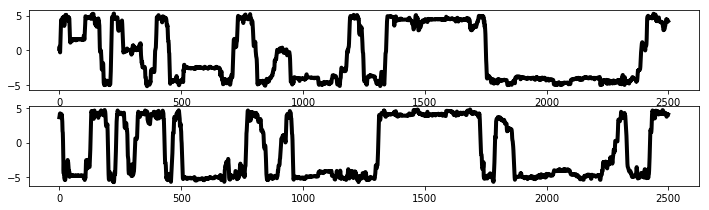

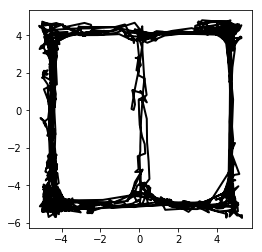

In [3]:
xDim = 2
yDim = 30
start_time = 0
all_time = 2500
datax = scipy.io.loadmat("spike30_sim_3000.mat")
z_true = scipy.io.loadmat("trj30_sim_3000.mat")
x_data = z_true["trj30_sim_3000"][start_time:all_time,:]
y_data = datax["spike30_sim_3000"][start_time:all_time,:]

# Define a neural network that maps the latent state into the output
gen_nn = lasagne.layers.InputLayer((None, xDim))
gen_nn = lasagne.layers.DenseLayer(gen_nn, 50, nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.Orthogonal())
gen_nn = lasagne.layers.DenseLayer(gen_nn, 50, nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.Orthogonal())
gen_nn = lasagne.layers.DenseLayer(gen_nn, 50, nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.Orthogonal())
gen_nn = lasagne.layers.DenseLayer(gen_nn, yDim, nonlinearity=linear, W=lasagne.init.Orthogonal())
Wg0 = np.asarray(gen_nn.W.get_value(), dtype=theano.config.floatX)
gen_nn.W.set_value( (Wg0).astype(theano.config.floatX) )

gen_nn = dict([('network', gen_nn)])

# #Put all the parameters in a dictionary
gendict = dict([('A'     , 0.8*np.eye(xDim)),         # Linear dynamics parameters
                ('QChol' , 1*np.diag(np.ones(xDim))), # innovation noise
                ('Q0Chol', 1*np.diag(np.ones(xDim))), 
                ('x0'    , np.zeros(xDim)), 
#                ('RChol', np.ones(yDim)),             # observation covariance
                ('NN_XtoY_Params',gen_nn),    # neural network output mapping
                ('output_nlin' , 'softplus')  # for poisson observations
                ])

# Instantiate a PLDS generative model:
true_model = PLDS(gendict, xDim, yDim, srng = msrng, nrng = mnrng)
#print(y_data.shape)
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(311)
ax1.plot(x_data[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(x_data[:, 1], lw=4, color='k')
#print(lasagne.layers.get_all_param_values(gen_nn))
plt.figure(figsize=(4, 4))
plt.plot(*x_data.T, lw = 2, color='k')

In [4]:
#for i in range(yDim):
#    plt.figure(figsize=(12, 3))
#    plt.plot(y_data[:,i])
#    plt.ylim(0,15)
#true_model.evaluateLogDensity(x_data[:100], y_data[:100])[0].eval()

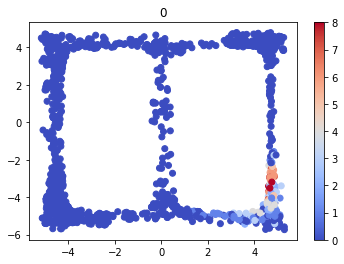

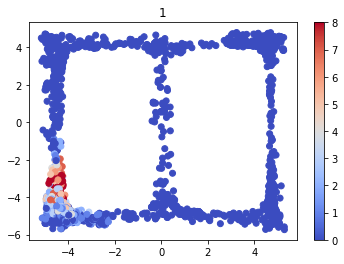

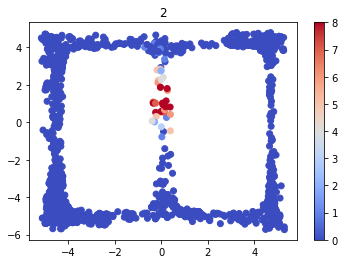

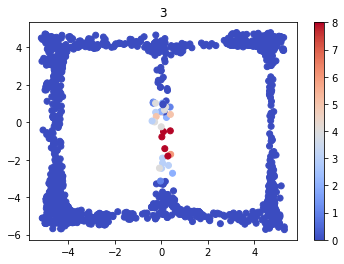

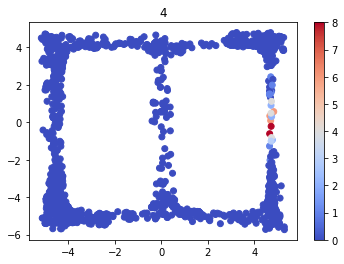

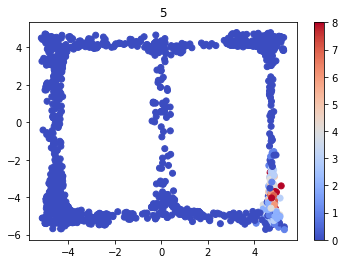

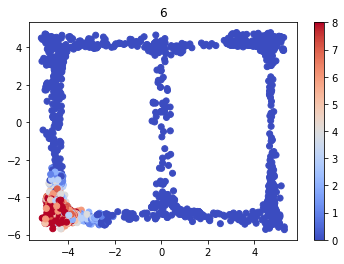

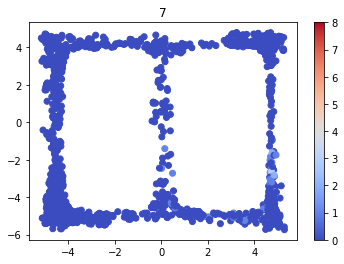

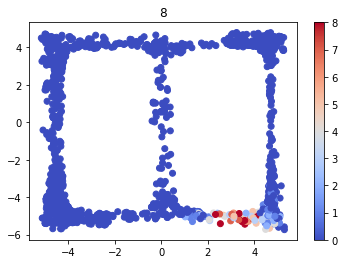

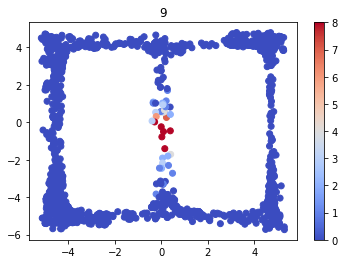

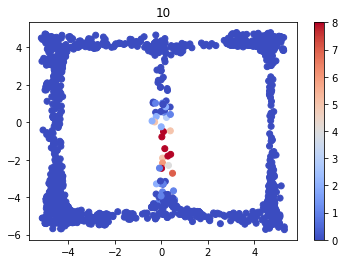

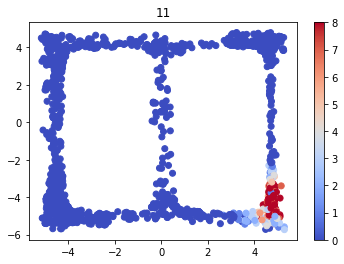

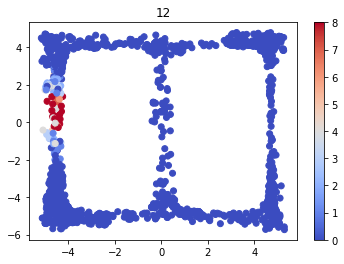

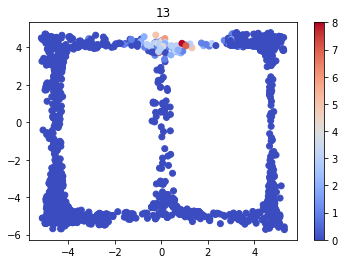

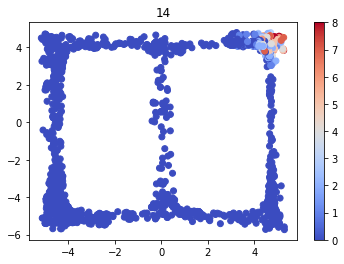

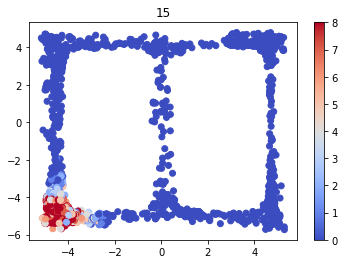

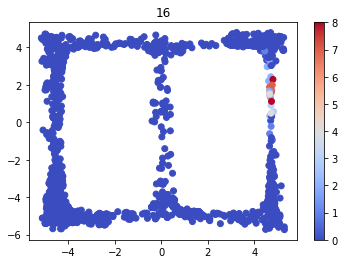

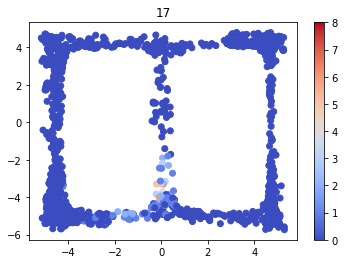

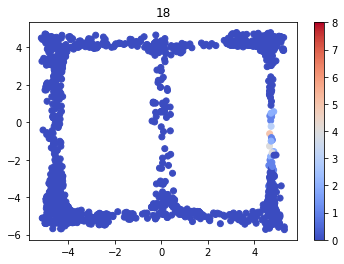

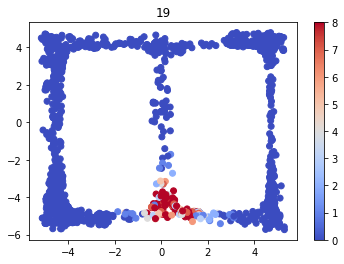

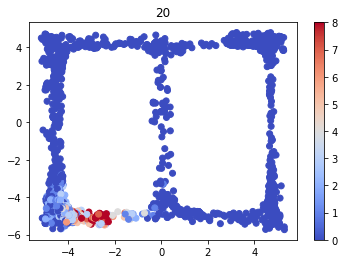

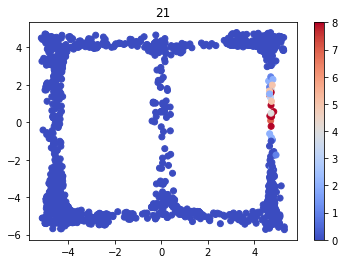

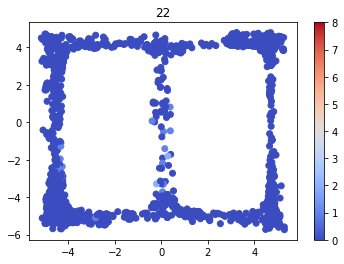

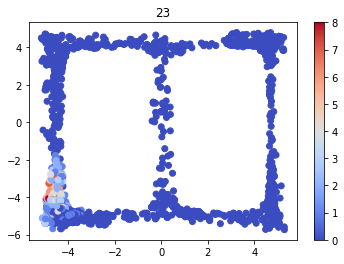

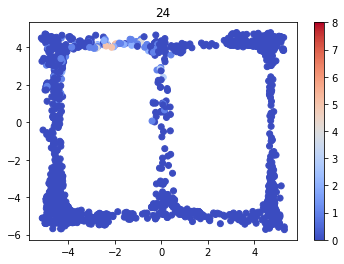

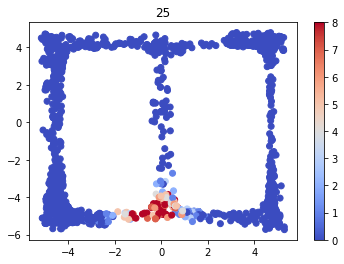

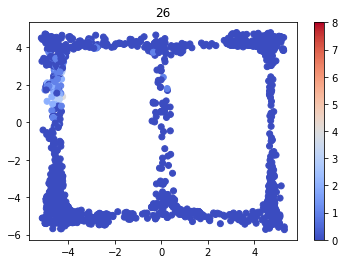

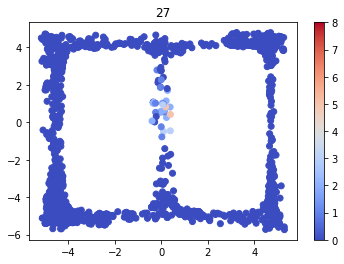

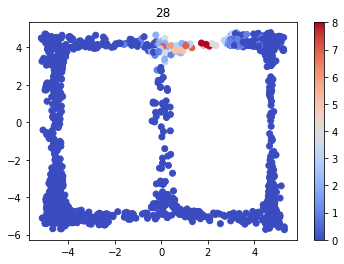

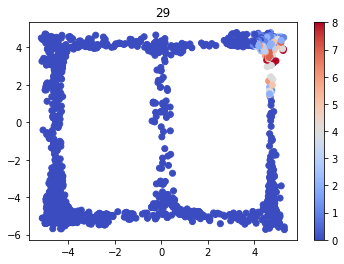

In [5]:
for i in range(yDim):
    fig, ax = plt.subplots()
    mappable = ax.scatter(x_data[:,0], x_data[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=8)
    fig.colorbar(mappable)
    plt.title(i)
    plt.show()
#fig.savefig("img.png")

# Recognition Model ("approximate posterior")


Our goal is to learn the parameters of $p_\theta(y|x)$ and the posterior $p(x|y)$. 

Since the posterior is hard to compute for most generative models, we approximate it using a Gaussian. Because we're interested in timeseries, we've designed our approximation to be able to express temporal correlations in a computationally fast way. In the code, we call this the "SmoothingTimeSeries" and "SmoothingLDSTimeSeries" recognition models (corresponding to the two parameterizations in Sec. 4 of the paper). 


Text(0.5,1,'samples from an untrained approximate posterior')

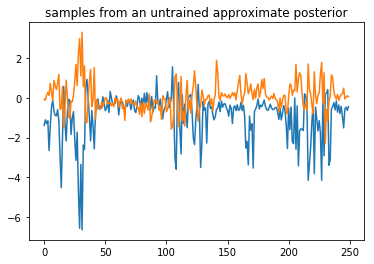

In [6]:
########################################
hidden = 50
hidden2 = 50
# Describe network for mapping into means
NN_Mu = lasagne.layers.InputLayer((None, yDim))
NN_Mu = lasagne.layers.DenseLayer(NN_Mu, hidden, nonlinearity=lasagne.nonlinearities.rectify,W=lasagne.init.Orthogonal())
NN_Mu1 = lasagne.layers.DenseLayer(NN_Mu, hidden, nonlinearity=lasagne.nonlinearities.rectify,W=lasagne.init.Orthogonal())
NN_Mu2 = lasagne.layers.DenseLayer(NN_Mu1, hidden2, nonlinearity=lasagne.nonlinearities.rectify,W=lasagne.init.Orthogonal())
#--------------------------------------
# let's initialize the first layer to have 0 mean wrt our training data
W0 = np.asarray(NN_Mu.W.get_value(), dtype=theano.config.floatX)
NN_Mu.W.set_value( (W0 / np.dot(y_data, W0).std(axis=0)).astype(theano.config.floatX) )
W0 = np.asarray(NN_Mu.W.get_value(), dtype=theano.config.floatX)
b0 = (-np.dot(y_data, W0).mean(axis=0)).astype(theano.config.floatX)
NN_Mu.b.set_value(b0)
#
W1 = np.asarray(NN_Mu1.W.get_value(), dtype=theano.config.floatX)
NN_Mu1.W.set_value( (W1 / np.dot(W0, W1).std(axis=0)).astype(theano.config.floatX) )
W1 = np.asarray(NN_Mu1.W.get_value(), dtype=theano.config.floatX)
b1 = (-np.dot(W0, W1).mean(axis=0)).astype(theano.config.floatX)
NN_Mu1.b.set_value(b1)
#
W20 = np.asarray(NN_Mu2.W.get_value(), dtype=theano.config.floatX)
NN_Mu2.W.set_value( (W20 / np.dot(W1, W20).std(axis=0)).astype(theano.config.floatX) )
W20 = np.asarray(NN_Mu2.W.get_value(), dtype=theano.config.floatX)
b20 = (-np.dot(W1, W20).mean(axis=0)).astype(theano.config.floatX)
NN_Mu2.b.set_value(b20)
#--------------------------------------
NN_Mu = lasagne.layers.DenseLayer(NN_Mu2, xDim, nonlinearity=linear, W=lasagne.init.Normal())
NN_Mu.W.set_value(NN_Mu.W.get_value()*10)
NN_Mu = dict([('network', NN_Mu)])

########################################
# Describe network for mapping into Covariances
NN_Lambda = lasagne.layers.InputLayer((None, yDim))
NN_Lambda = lasagne.layers.DenseLayer(NN_Lambda, hidden, nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.Orthogonal())
NN_Lambda1 = lasagne.layers.DenseLayer(NN_Lambda, hidden, nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.Orthogonal())
NN_Lambda2 = lasagne.layers.DenseLayer(NN_Lambda1, hidden2, nonlinearity=lasagne.nonlinearities.rectify,W=lasagne.init.Orthogonal())
#--------------------------------------
# let's initialize the first layer to have 0 mean wrt our training data
W0 = np.asarray(NN_Lambda.W.get_value(), dtype=theano.config.floatX)
NN_Lambda.W.set_value( (W0 / np.dot(W0, W1).std(axis=0)).astype(theano.config.floatX) )
W0 = np.asarray(NN_Lambda.W.get_value(), dtype=theano.config.floatX)
b0 = (-np.dot(y_data, W0).mean(axis=0)).astype(theano.config.floatX)
NN_Lambda.b.set_value(b0)
#
W1 = np.asarray(NN_Lambda1.W.get_value(), dtype=theano.config.floatX)
NN_Lambda1.W.set_value( (W1 / np.dot(W0, W1).std(axis=0)).astype(theano.config.floatX) )
W1 = np.asarray(NN_Lambda1.W.get_value(), dtype=theano.config.floatX)
b1 = (-np.dot(W0, W1).mean(axis=0)).astype(theano.config.floatX)
NN_Lambda1.b.set_value(b1)
#
W20 = np.asarray(NN_Lambda2.W.get_value(), dtype=theano.config.floatX)
NN_Lambda2.W.set_value( (W20 / np.dot(W1, W20).std(axis=0)).astype(theano.config.floatX) )
W20 = np.asarray(NN_Lambda2.W.get_value(), dtype=theano.config.floatX)
b20 = (-np.dot(W1, W20).mean(axis=0)).astype(theano.config.floatX)
NN_Lambda2.b.set_value(b20)
#--------------------------------------
NN_Lambda = lasagne.layers.DenseLayer(NN_Lambda2, xDim*xDim, nonlinearity=linear, W=lasagne.init.Orthogonal())
NN_Lambda.W.set_value(NN_Lambda.W.get_value()*10)
NN_Lambda = dict([('network', NN_Lambda)])

########################################
# define dictionary of recognition model parameters
recdict = dict([('A'     , .9*np.eye(xDim)),
                ('QinvChol',  np.eye(xDim)), #np.linalg.cholesky(np.linalg.inv(np.array(tQ)))),
                ('Q0invChol', np.eye(xDim)), #np.linalg.cholesky(np.linalg.inv(np.array(tQ0)))),
                ('NN_Mu' ,NN_Mu),
                ('NN_Lambda',NN_Lambda),
                ])

########################################
# We can instantiate a recognition model alone and sample from it. 
# First, we have to define a Theano dummy variable for the input observations the posterior expects:
Y = T.matrix()
batch_size = 10
rec_model = SmoothingLDSTimeSeries(recdict, Y, xDim, yDim, srng = msrng, nrng = mnrng)
rsamp = rec_model.getSample()

# to look at a sample, we have to evaluate it at data:
plt.figure()
plt.plot(rsamp.eval({Y: y_data[:250]})) # here, the data are mapping into the parameters
plt.title('samples from an untrained approximate posterior')
#print(NN_Mu.W.get_value())

We train the generative model and recognition model together using gradient descent. We wrapped the SGVB objective function in the SGVB class. To train a generative and recognition model on data, we instantiate an instance of SGVB, passing in the GenerativeModel and RecognitionModel we wish to use (along with parameter dictionaries). 

In [7]:
sgvb = SGVB(gendict, PLDS, recdict, SmoothingLDSTimeSeries, xDim = xDim, yDim = yDim)
print(sgvb.getParams())

[<TensorType(float64, matrix)>, <TensorType(float64, matrix)>, <TensorType(float64, matrix)>, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, <TensorType(float64, matrix)>, <TensorType(float64, matrix)>, Q0Chol, x0, W, b, W, b, W, b, W, b]


In [8]:
########################################
class DatasetMiniBatchIndexIterator(object):
    def __init__(self, y, batch_size=100, randomize=False):
        self.y = y
        self.batch_size = batch_size
        self.randomize = randomize
        from sklearn.utils import check_random_state
        self.rng = np.random.RandomState(np.random.randint(12039210))

    def __iter__(self):
        n_samples = self.y.shape[0]
        #if n_samples == self.batch_size:
        #    yield [self.y, np.arange(n_samples)]
        if self.randomize:
            for _ in xrange(n_samples / self.batch_size):
                if self.batch_size > 1:
                    i = int(self.rng.rand(1) * ((n_samples-self.batch_size-1)))
                else:
                    i = int(math.floor(self.rng.rand(1) * n_samples))
                ii = np.arange(i, i + self.batch_size)
                yield [self.y[ii], ii]
        else:
            for i in xrange((n_samples + self.batch_size - 1)
                            / self.batch_size):
                ii = np.arange(i*self.batch_size,(i+1)*self.batch_size)
                yield [self.y[ii], ii]

In [9]:
# Define a bare-bones thenao training function
batch_y = T.matrix('batch_y')

# choose learning rate and batch size
lr_shared = theano.shared(np.array(0.005, dtype=theano.config.floatX)) # large lr cause error
updates = lasagne.updates.adam(-sgvb.cost()[0], sgvb.getParams(), learning_rate=lr_shared)
print(sgvb.getParams())
# Finally, compile the function that will actually take gradient steps. 
train_fn = theano.function(
         outputs=sgvb.cost(),
         inputs=[theano.In(batch_y)],
         updates=updates,
         givens={sgvb.Y: batch_y},
    )

('A', array([[0.8, 0. ],
       [0. , 0.8]]))
('A', array([[0.8, 0. ],
       [0. , 0.8]]))
[<TensorType(float64, matrix)>, <TensorType(float64, matrix)>, <TensorType(float64, matrix)>, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, <TensorType(float64, matrix)>, <TensorType(float64, matrix)>, Q0Chol, x0, W, b, W, b, W, b, W, b]
('A', array([[0.8, 0. ],
       [0. , 0.8]]))
('A', array([[0.8, 0. ],
       [0. , 0.8]]))


In [10]:
# set up an iterator over our training data
yiter = DatasetMiniBatchIndexIterator(y_data, batch_size=batch_size, randomize=True)

# Iterate over the training data for the specified number of epochs
n_epochs = 50
cost = []
dir_loss = []
for ie in np.arange(n_epochs):
    print('--> entering epoch %d' % ie)
    if ie%5 == 0:
            lr_shared.set_value(lr_shared.get_value() / 2) # large lr cause error (for exp(x)->inf)
            print("lr",lr_shared.get_value())
    for y, _ in yiter:
        cost.append(train_fn(y)[0])
        dir_loss.append(train_fn(y)[2])
        #print("dir",train_fn(y)[2],"lik",train_fn(y)[3],"smo",train_fn(y)[4])

--> entering epoch 0
('lr', array(0.0025))
--> entering epoch 1
--> entering epoch 2
--> entering epoch 3
--> entering epoch 4
--> entering epoch 5
('lr', array(0.00125))
--> entering epoch 6
--> entering epoch 7
--> entering epoch 8
--> entering epoch 9
--> entering epoch 10
('lr', array(0.000625))
--> entering epoch 11
--> entering epoch 12
--> entering epoch 13
--> entering epoch 14
--> entering epoch 15
('lr', array(0.0003125))
--> entering epoch 16
--> entering epoch 17
--> entering epoch 18
--> entering epoch 19
--> entering epoch 20
('lr', array(0.00015625))
--> entering epoch 21
--> entering epoch 22
--> entering epoch 23
--> entering epoch 24
--> entering epoch 25
('lr', array(7.8125e-05))
--> entering epoch 26
--> entering epoch 27
--> entering epoch 28
--> entering epoch 29
--> entering epoch 30
('lr', array(3.90625e-05))
--> entering epoch 31
--> entering epoch 32
--> entering epoch 33
--> entering epoch 34
--> entering epoch 35
('lr', array(1.953125e-05))
--> entering epoc

C:\Users\kdais\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


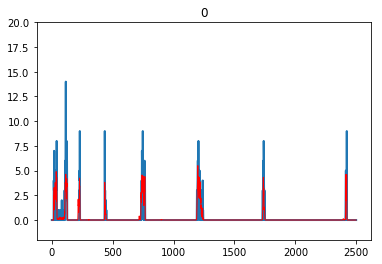

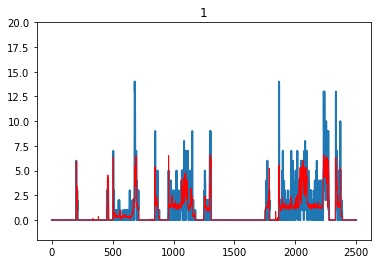

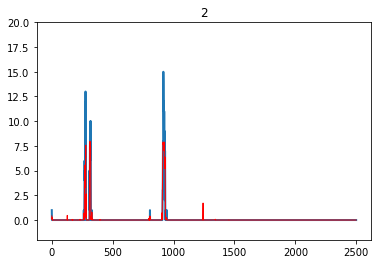

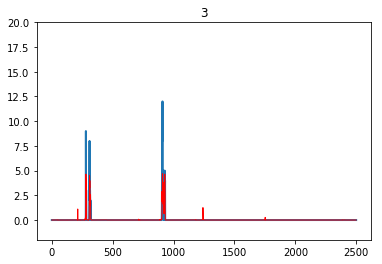

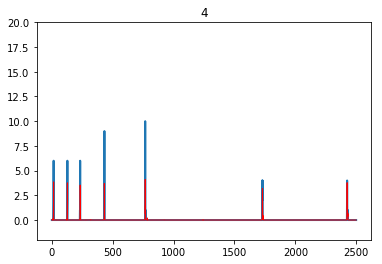

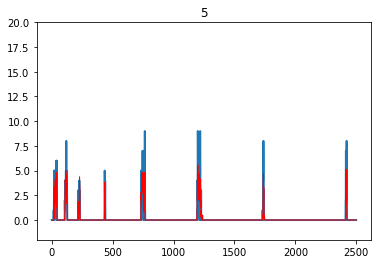

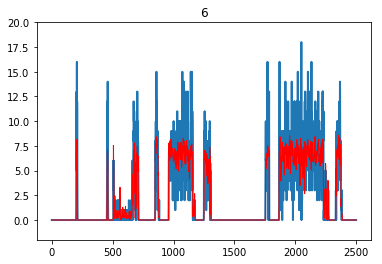

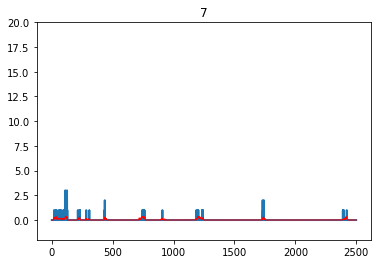

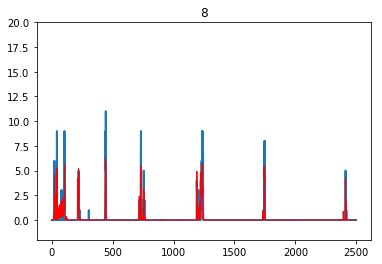

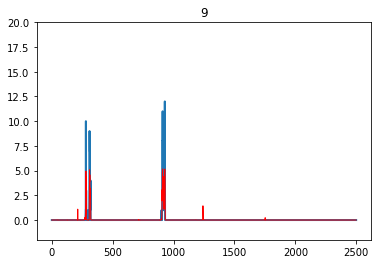

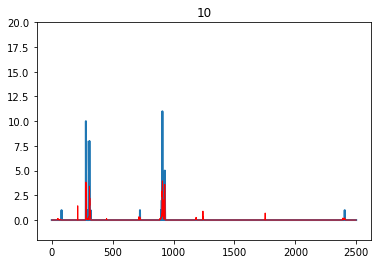

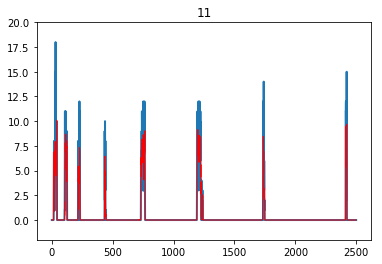

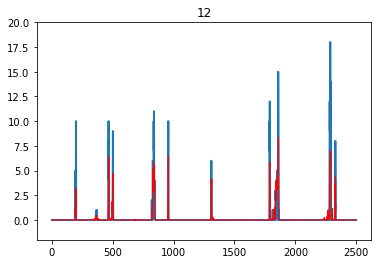

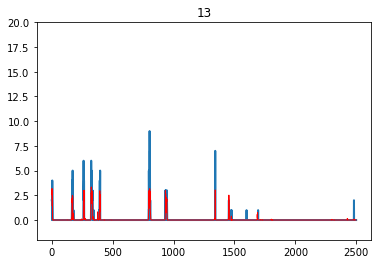

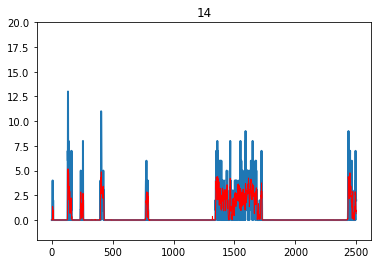

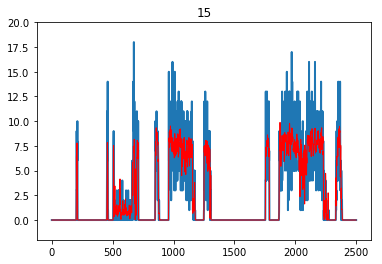

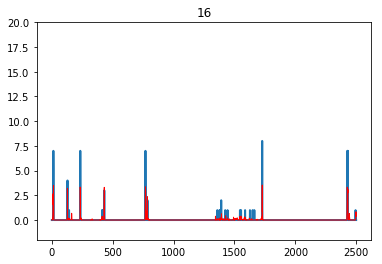

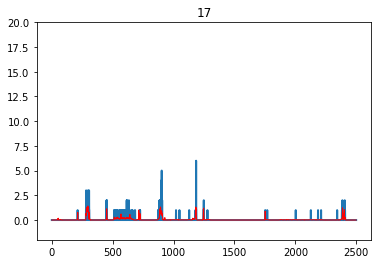

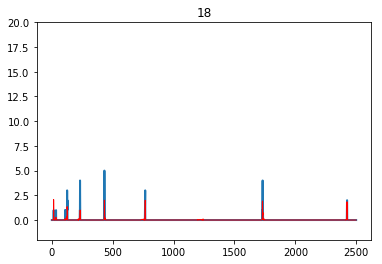

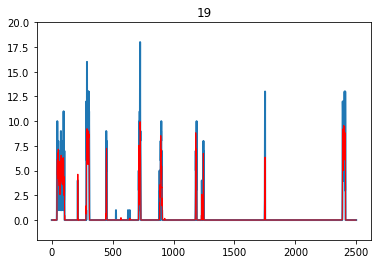

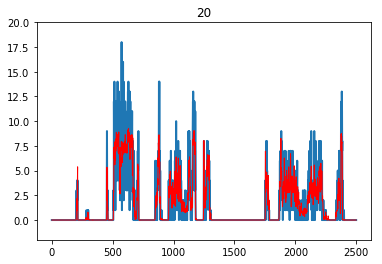

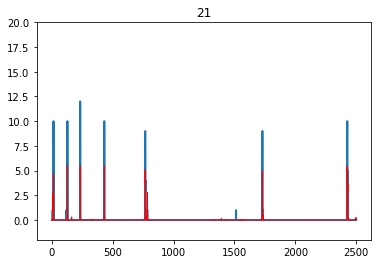

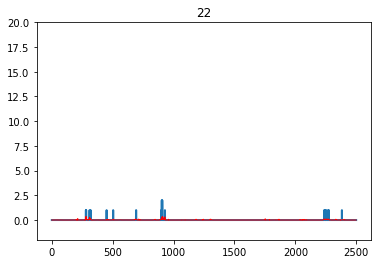

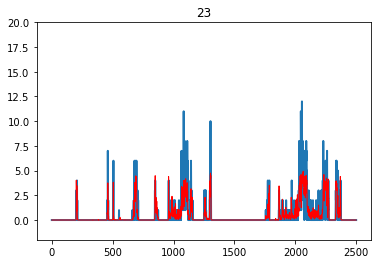

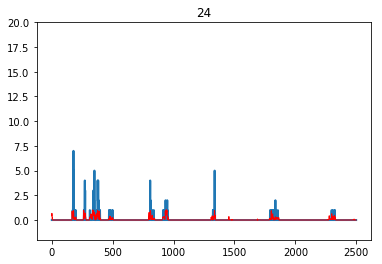

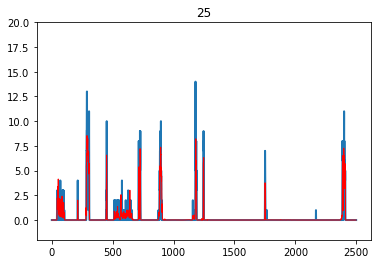

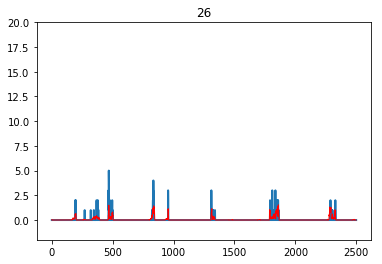

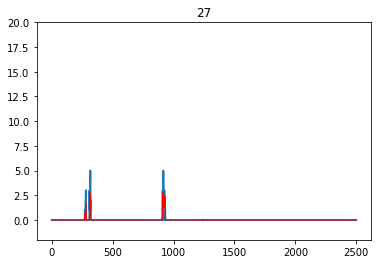

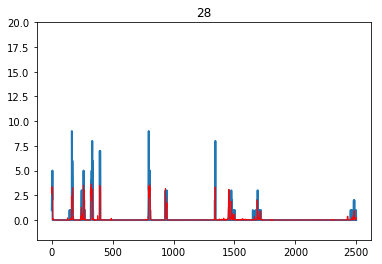

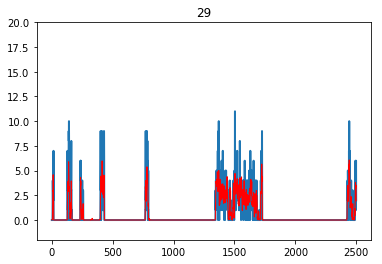

In [11]:
py = train_fn(y_data)[1]
for i in range(yDim):
    plt.figure()
    plt.plot(y_data[:,i], linewidth = 2)
    plt.plot(py[:,i],'r',linewidth = 1)
    plt.title(i)
    plt.ylim(-2,20)

('A', array([[0.8, 0. ],
       [0. , 0.8]]))


(-500, 0)

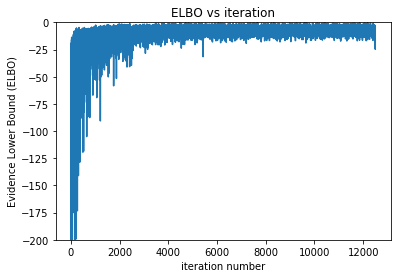

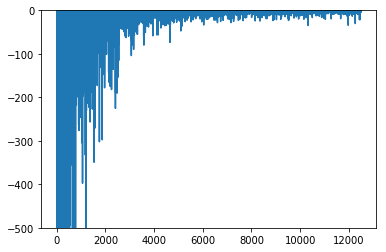

In [12]:
plt.plot(cost[1:])
#plt.plot(dir_loss[1:])
plt.title('ELBO vs iteration')
plt.xlabel('iteration number')
plt.ylabel('Evidence Lower Bound (ELBO)')
plt.ylim(-200,0)
true_model.evaluateLogDensity(x_data[:100], y_data[:100])[0].eval()
#print(lasagne.layers.get_all_param_values(NN_Mu))
plt.figure()
plt.plot(dir_loss)
plt.ylim(-500,0)

We can access the trained generative and recognition models through the SGVB object, just as before.

In [13]:
#########################
# Since the model is non-identifiable, let's find the best linear projection from the
# learned posterior mean into the 'true' training-data latents
pM = sgvb.mrec.postX.eval({sgvb.Y: y_data})
wgt = np.linalg.lstsq(pM-pM.mean(), x_data-x_data.mean())[0] 
#plt.plot(pM[:,0])
#plt.plot(pM[:,1])

C:\Users\kdais\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


C:\Users\kdais\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\kdais\Anaconda3\envs\py27\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\kdais\Anaconda3\envs\py27\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


((2500L, 2L), (2L, 2L))


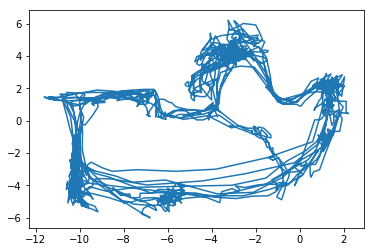

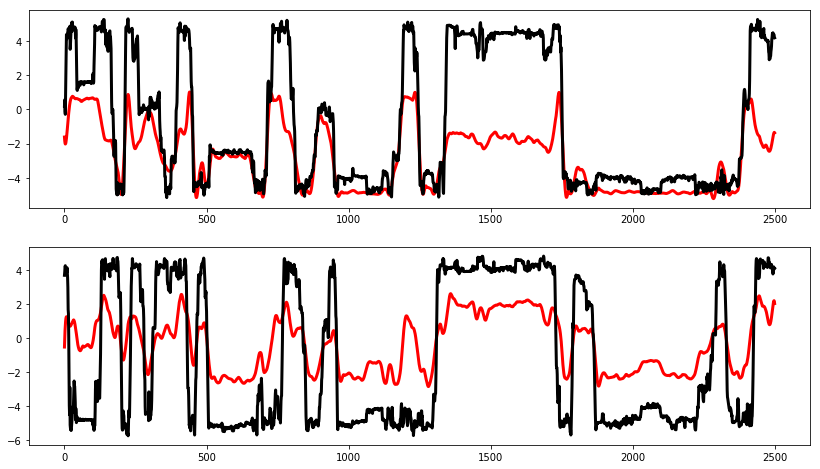

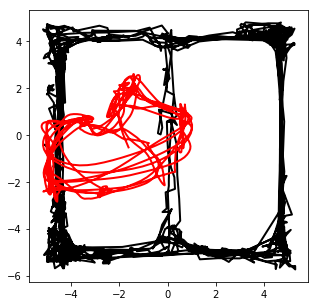

In [14]:
x_test = x_data
y_test = y_data

# sample from the trained recognition model
rtrain_samp = sgvb.mrec.getSample()

plt.hold('on')

import funs
# plot 25 samples from the posterior
#for idx in np.arange(25): # plot multiple samples from the posterior
    #xs = rtrain_samp.eval({sgvb.Y: y_test})
    #plt.plot(np.dot(xs,wgt),'k')
# and now plot the posterior mean
pMtest = sgvb.mrec.postX.eval({sgvb.Y: y_test})
#plt.subplot(211)
#plt_post = plt.plot(np.dot(pMtest,wgt)[:,0],'r', linewidth = 3, label = 'posterior mean')
#plt_true = plt.plot(x_test[:,0], 'k', linewidth = 3, label = '\"true\" mean')
#plt.subplot(212)
#plt_post = plt.plot(np.dot(pMtest,wgt)[:,1],'r', linewidth = 3, label = 'posterior mean')
#plt_true = plt.plot(x_test[:,1], 'k', linewidth = 3, label = '\"true\" mean')

#plt.legend(handles = plt_post + plt_true)
#plt.xlabel('time')
#plt.title('samples from the trained approximate posterior')
qz_mean_est = pMtest#np.dot(pMtest,wgt)*2
#plt.plot(qz_mean_est[:,0])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
print(pMtest.shape,wgt.shape)
z_true_c = x_test# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')

In [15]:
#np.savetxt('pflds_k09.csv', qz_est_norm_R, delimiter=',')